In [1]:
!pip install openpyxl

import numpy as np
import pandas as pd
from itertools import combinations
from itertools import permutations
import seaborn

from WarehouseObj import PalletPos
from PickingObj import PickingObj
from Picking import Picking
from Tools import Tools
import sqlite3

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Pre-running
The following code is to use SQLite database to analyze data.
NO NEED to run it again!

In [ ]:
# ------------------------------------------------------------------
# (1) Create database connection 
db = sqlite3.connect("ISYE6335_proj.db")
cur = db.cursor()
# ------------------------------------------------------------------
# (2) Read data from "order_data.csv" (which is directly converted from "Jefferson_Order_Data.xlsx")
df = pd.read_csv("order_data.csv")
# Change the type of datetime from "Wednesday, February 23, 2022" to "2022-02-23"
df['Date'] = pd.to_datetime(df['OBD_DATE'])
dateList = []
for i in df['Date']:
    try:
        dateList.append(i.strftime("%Y-%m-%d"))
    except:
        dateList.append('0001-01-01')
df['strDate'] = dateList
# ------------------------------------------------------------------
# (3) Create table `Orders` from "order_data.csv"
cur.execute("Drop table if exists Orders")
cur.execute('''
Create table if not exists Orders (
    `Material Number` Text,
    `ORDERCATEGORY` Text,
    `Pick Date` Text,
    `Layers Ordered Rounded` Int(10)
)
''')
# Insert the rows from DataFrame into SQL table
rows = df[["Material Number", "ORDERCATEGORY", "strDate", "Layers Ordered Rounded"]].values.tolist()
cur.executemany("Insert into Orders VALUES (?,?,?,?)", rows)
# ------------------------------------------------------------------
# (4) Create table `LayersDailyPicking` from table `Orders`
cur.execute("Drop table if exists LayersDailyPicking")
cur.execute('''
Create table if not exists LayersDailyPicking (
    `SKU_ID` Text,
    `Count(layers)` Int(10),
    `Pick Date` Text
)
''')

cur.execute('''
Insert into LayersDailyPicking
Select
    `Material Number`,
    sum(`Layers Ordered Rounded`) as `Count(layers)`,
    `Pick Date`
from Orders 
where `ORDERCATEGORY` = 'Shipped'
and `Layers Ordered Rounded` > 0
group by `Pick Date`, `Material Number`
order by `Pick Date` asc
''')
# ------------------------------------------------------------------
# (5) Read data from "Newest Slotter.csv"
df = pd.read_csv("Newest Slotter.csv")
rows = df[['Location', 'New Item']].values.tolist()
# ------------------------------------------------------------------
# (6) Create table `Slotting` from "Newest Slotter.csv"
cur.execute("Drop table if exists Slotting")
cur.execute('''
Create table if not exists Slotting (
    `Location` Text,
    `New Item` Text
)
''')
cur.executemany("Insert into Slotting VALUES (?,?)", rows)
# ------------------------------------------------------------------
# (7) Finish
db.commit()
cur.close()
db.close()

# Main

Main body
Start running from here
Query data from database

In [4]:
db = sqlite3.connect("ISYE6335_proj.db")
cur = db.cursor()

In [5]:
cur.execute('''
Select
    L.`SKU_ID`,
    L.`Count(layers)`,
    L.`Pick Date`,
    S.`Location`
from LayersDailyPicking L
left join Slotting S
on L.`SKU_ID` = S.`New Item`
where length(S.`Location`) > 4
''')

rs = cur.fetchall()
df_picking = pd.DataFrame(rs)
df_picking.columns = ['New Item', 'layers', 'date', 'Location']
df_picking.head()

,New Item,layers,date,Location
0,19200-75352-31,3,2021-01-01,801-12-A-01
1,19200-79329-34,4,2021-01-03,801-43-A-01
2,19200-00706-01,6,2021-01-04,801-31-A-01
3,19200-78033-02,5,2021-01-04,801-78-A-01
4,19200-78626-05,2,2021-01-04,801-15-A-01


## 2.1 Layout
**Original layout**

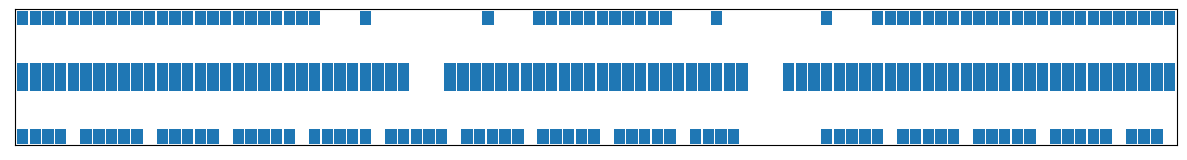

In [ ]:
pps1 = PalletPos()
pps1.ReadLocationFromCSV('layout.csv')
pps1.PlotLayout()

**Changed layout**

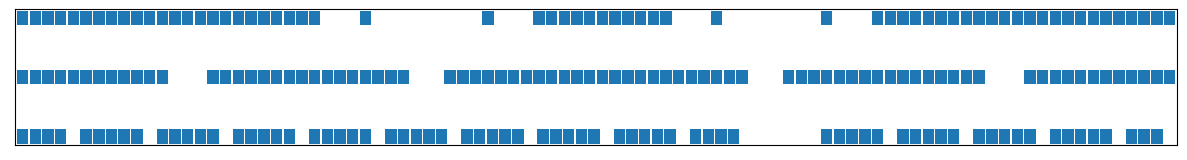

In [ ]:
pps2 = PalletPos()
pps2.ReadLocationFromCSV('layout_new.csv')
pps2.PlotLayout()

## 2.2 Heat Map
**Original Heatmap**

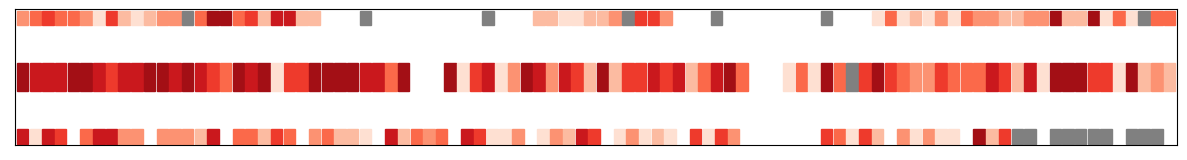

In [ ]:
pps1.ReadFrequencyFromCSV("freq_post.csv")
pps1.PlotHeatMap()

**Heatmap of layout after aisle change and SKU reallocation**

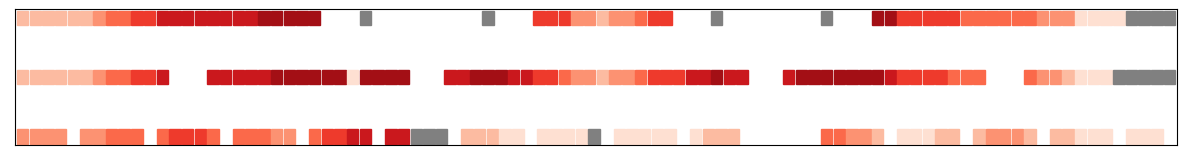

In [ ]:
pps2.ReadFrequencyFromCSV("freq_post_new.csv")
pps2.PlotHeatMap()

## 2.3 Pick For One Specific Day

### 2.3.1 Original layout

In [2]:
pko1 = PickingObj(aisles_x=[145.5, 265.5],layoutFileDir="layout.csv",ifCorrectPosKeys=True)
pko1.getPosClass()
pko1.getPairDistance(if_saveToExcel=False, outputFileDir="Pair_Distance.xlsx")
pko1.getSKUPosDict(fileDir="locationToSKU.csv")

Group by daily to get the daily layers picking tasks

In [6]:
grouping = df_picking.groupby('date')
dfs = []
for day in grouping.indices.keys():
    data = grouping.get_group(day)
    data['Class']= np.nan
    for i in data.index:
        data.loc[i,'Class'] = pko1.posClsDict[data.loc[i,'Location']]
    dfs.append(data)
dfs[-1]

,New Item,layers,date,Location,Class
32299,19200-00706-01,1,2022-08-29,801-31-A-01,0.0
32300,19200-02569-17,1,2022-08-29,801-21-A-01,0.0
32301,19200-02699-31,1,2022-08-29,801-10-A-01,0.0
32302,19200-75352-31,2,2022-08-29,801-12-A-01,0.0
32303,19200-80306-02,2,2022-08-29,801-90-A-01,1.0
32304,19200-83262-02,1,2022-08-29,801-33-A-01,0.0
32305,19200-89289-00,1,2022-08-29,801-30-A-01,0.0
32306,19200-95872-00,1,2022-08-29,801-22-A-01,0.0
32307,19200-98015-01,1,2022-08-29,801-56-A-01,0.0
32308,19200-98016-01,1,2022-08-29,801-54-A-01,0.0


In [7]:
df = dfs[-1].copy()
pk1 = Picking(pko1, df)
pk1.picking()
print("Total travel distance: ", str(pk1.travelDistance))
pk1.Routes

Total travel distance:  499.5


[[[['801-22-A-01', '801-21-A-01', 1, 12.0],
   ['801-30-A-01', '801-21-A-01', 1, 30.0],
   ['801-30-A-01', '801-31-A-01', 1, 16.5],
   ['801-31-A-01', '801-33-A-01', -1, 16.5]],
  [['801-54-A-01', '801-56-A-01', -1, 16.5],
   ['LAY427', '801-56-A-01', 0, 30.0],
   ['LAY418', '801-54-A-01', 0, 39.0]],
  [['801-10-A-01', '801-12-A-01', -1, 16.5],
   ['801-10-A-01', '801-05-A-01', 1, 21.0]],
  [['LAY419', '801-01-A-01', -1, 225.0]],
  [['LAY403']]],
 [[['801-90-A-01', '801-94-A-01', -1, 21.0]]],
 [[['801-160-A-01']],
  [['801-142-A-01', '801-143-A-01', 1, 16.5]],
  [['801-140-A-01', '801-152-A-01', -1, 39.0]]]]

### 2.3.2 Changed layout

In [8]:
pko2 = PickingObj(aisles_x=[60.75, 145.5, 265.5, 332.25], layoutFileDir="layout_new.csv", ifCorrectPosKeys=True)
pko2.getPosClass()
pko2.getPairDistance(if_saveToExcel=False, outputFileDir="Pair_Distance_new.xlsx")
pko2.getSKUPosDict(fileDir="locationToSKU_new.csv")

In [9]:
df = dfs[-1].copy()
pk2 = Picking(pko2, df)
pk2.picking()
print("Total travel distance: ", str(pk2.travelDistance))
pk2.Routes

Total travel distance:  437.25


[[[['801-31-A-01', '801-33-A-01', -1, 16.5],
   ['801-21-A-01', '801-31-A-01', -1, 34.5],
   ['801-22-A-01', '801-31-A-01', -1, 36.75],
   ['801-10-A-01', '801-22-A-01', -1, 39.0]],
  [['801-54-A-01', '801-56-A-01', -1, 16.5],
   ['LAY427', '801-56-A-01', -1, 39.75],
   ['LAY418', 'LAY427', -1, 61.5]],
  [['801-01-A-01', '801-05-A-01', -1, 21.0],
   ['801-12-A-01', '801-05-A-01', -1, 99.75]],
  [['801-30-A-01']],
  [['LAY403']],
  [['LAY419']]],
 [[['801-90-A-01', '801-94-A-01', -1, 21.0]]],
 [[['801-160-A-01']],
  [['801-140-A-01', '801-142-A-01', -1, 16.5],
   ['801-142-A-01', '801-152-A-01', -1, 34.5]],
  [['801-143-A-01']]]]

## 2.4 Pick for all days

In [10]:
from tqdm import tqdm

tds1 = []
for day in tqdm(range(len(dfs))):
    df = dfs[day].copy()
    pk = Picking(pko1, df)
    pk.picking()
    tds1.append(pk.travelDistance)

100%|██████████| 539/539 [5:13:43<00:00, 34.92s/it]


In [11]:
sum(tds1)

29044.5

380083.5

In [12]:
tds2 = []
for day in tqdm(range(len(dfs))):
    df = dfs[day].copy()
    pk = Picking(pko2, df)
    pk.picking()
    tds2.append(pk.travelDistance)

  1%|          | 4/539 [00:05<11:09,  1.25s/it]


KeyboardInterrupt: 

In [ ]:
sum(tds2)

39533.25

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8341127f-7ca7-4b3c-9f1f-15a15ff869e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>